# 03 - Metabolic Flux Estimation

This notebook demonstrates metabolic flux estimation using scFEA (single-cell Flux Estimation Analysis).

## Overview

scFEA is a graph neural network-based tool designed specifically for estimating metabolic flux from scRNA-seq data. Unlike traditional FBA approaches, scFEA:
- Uses machine learning trained on known metabolic networks
- Predicts cell-specific flux values from gene expression
- Works with sparse scRNA-seq data
- Focuses on 719 curated metabolic genes

Steps include:
1. Load annotated single-cell data
2. Prepare expression matrix for scFEA
3. Run scFEA flux estimation
4. Analyze cell type-specific metabolism
5. Compare metabolic profiles

## Setup

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import subprocess
from pathlib import Path

# Configure
sc.settings.verbosity = 1

print(f"Scanpy version: {sc.__version__}")
print("\nNote: scFEA runs as a command-line tool. This notebook prepares data and calls scFEA.")

Scanpy version: 1.11.5

Note: scFEA runs as a command-line tool. This notebook prepares data and calls scFEA.


C:\Users\dell\AppData\Local\Temp\ipykernel_3412\3659820803.py:14: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


In [3]:
# Add suffix for updated output names
suffix = "combined.26.01.26"

## Load Configuration and Data

In [5]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Check if annotated data exists and try to load it
annotated_file = f"../data/processed/{suffix}/annotated_data.h5ad"

if not os.path.exists(annotated_file):
    print(f"❌ File not found: {annotated_file}")
    print("\nYou need to run 02_cell_type_annotation.ipynb first to generate the annotated data.")
else:
    print(f"✓ File found: {annotated_file}")
    file_size_mb = os.path.getsize(annotated_file) / (1024 * 1024)
    print(f"  File size: {file_size_mb:.2f} MB")
    
    try:
        # Try to load annotated data
        print("\nLoading annotated data...")
        adata = sc.read_h5ad(annotated_file)
        
        print(f"✓ Successfully loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
        print(f"Cell types: {adata.obs['cell_type'].nunique()}")
        
        # Check for stage information
        if 'stage' in adata.obs.columns:
            print(f"✓ Stage information available")
            print(f"  Stages: {adata.obs['stage'].unique()}")
        else:
            print("⚠️ No stage information found - you may need to re-run 02_cell_type_annotation.ipynb")
            
    except Exception as e:
        print(f"❌ Error loading file: {type(e).__name__}")
        print(f"   {str(e)[:200]}")
        print("\nTROUBLESHOOTING:")
        print("1. The h5ad file may be corrupted")
        print("2. Close any programs that might be accessing the file")
        print("3. Re-run the last cell in 02_cell_type_annotation.ipynb to save the data again")
        print("4. If the problem persists, try deleting the file and re-running the annotation notebook")
        
        # Try alternative: load from CSV if available
        csv_file = f"../data/processed/{suffix}/expression_matrix.csv"
        if os.path.exists(csv_file):
            print(f"\n✓ Alternative: Expression matrix CSV found")
            print("  You can recreate the annotated object from CSV files")
        
        adata = None

if 'adata' in locals() and adata is not None:
    adata

✓ File found: ../data/processed/combined.26.01.26/annotated_data.h5ad
  File size: 715.03 MB

Loading annotated data...
✓ Successfully loaded data: 10779 cells x 21406 genes
Cell types: 10
✓ Stage information available
  Stages: ['estrus', 'diestrus']
Categories (2, object): ['estrus', 'diestrus']


## Prepare Expression Matrix for scFEA

scFEA requires:
- Expression matrix: genes (rows) × cells (columns)
- Gene names matching scFEA's metabolic gene list
- Values: normalized, log-transformed expression

In [6]:
# Load scFEA metabolic gene list
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"scFEA metabolic genes: {len(scfea_genes)}")

# Check overlap with our data
genes_in_data = [g for g in scfea_genes if g in adata.var_names]
print(f"Genes found in dataset: {len(genes_in_data)} ({100*len(genes_in_data)/len(scfea_genes):.1f}%)")
print(f"Missing genes: {len(scfea_genes) - len(genes_in_data)}")

# Get expression matrix for scFEA genes only
if 'log1p_norm' in adata.layers:
    expr_matrix = adata[:, genes_in_data].layers['log1p_norm'].toarray()
else:
    expr_matrix = adata[:, genes_in_data].X.toarray()

# Create DataFrame: genes (rows) × cells (columns)
expr_df = pd.DataFrame(
    expr_matrix.T,  # Transpose to genes × cells
    index=genes_in_data,
    columns=adata.obs_names
)

print(f"\nExpression matrix shape: {expr_df.shape}")
print(f"  Genes (rows): {expr_df.shape[0]}")
print(f"  Cells (columns): {expr_df.shape[1]}")

scFEA metabolic genes: 719
Genes found in dataset: 578 (80.4%)
Missing genes: 141

Expression matrix shape: (578, 10779)
  Genes (rows): 578
  Cells (columns): 10779


## Export Data for scFEA

Save expression matrix in format required by scFEA.

In [21]:
# Create scFEA output directory
scfea_dir = Path(f'../results/scfea/{suffix}')
scfea_dir.mkdir(parents=True, exist_ok=True)

# Save expression matrix for scFEA
# scFEA expects: genes (rows) × cells (columns), CSV format
expr_file = scfea_dir / 'expression_input.csv'
expr_df.to_csv(expr_file)
print(f"Saved expression matrix to: {expr_file}")

# Save cell metadata for later analysis - include stage if available
metadata_file = scfea_dir / 'cell_metadata.csv'
metadata_cols = ['cell_type']
if 'stage' in adata.obs.columns:
    metadata_cols.append('stage')
    print(f"✓ Including stage information in metadata")
else:
    print(f"⚠️ No stage information found - saving cell_type only")

adata.obs[metadata_cols].to_csv(metadata_file)
print(f"Saved cell metadata to: {metadata_file}")
print(f"  Columns saved: {metadata_cols}")

print(f"\nExpression matrix: {expr_df.shape[0]} genes × {expr_df.shape[1]} cells")
print(f"Ready for scFEA analysis!")

Saved expression matrix to: ..\results\scfea\combined.26.01.26\expression_input.csv
✓ Including stage information in metadata
Saved cell metadata to: ..\results\scfea\combined.26.01.26\cell_metadata.csv
  Columns saved: ['cell_type', 'stage']

Expression matrix: 578 genes × 10779 cells
Ready for scFEA analysis!


## Run scFEA

scFEA runs as a command-line tool. You can run it in terminal or from this notebook.

In [8]:
# scFEA usage instructions

print("=" * 70)
print("scFEA Usage")
print("=" * 70)

print("\nSTEP 0: Install scFEA Dependencies")
print("-" * 70)
print("First, install required packages:")
print()
print("pip install torch torchvision")
print("pip install scikit-learn pandas numpy")
print("pip install python-magic-bin")
print()
print("NOTE: This may take a few minutes")
print()

print("STEP 1: Navigate to scFEA directory")
print("-" * 70)
print("  cd Z:/thornes/Pavlicev_lab_rotation/scFEA")
print()

print("STEP 2: Run scFEA")
print("-" * 70)
print("IMPORTANT: Make sure scFEA's data files are present!")
print()
print("Check that these files exist in scFEA/data/:")
print("  - module_gene_m168.csv")
print("  - cmMat_c70_m168.csv")
print("  - (other .csv files)")
print()
print("For PowerShell (Windows), use backticks for line continuation:")
print()
print("python src/scFEA.py `")
print("    --data_dir data `")
print("    --input_dir ../FLUXestimator/results/scfea/combined.26.01.26 `")  
print("    --res_dir ../FLUXestimator/results/scfea/combined.26.01.26 `")
print("    --test_file expression_input.csv `")
print("    --moduleGene_file module_gene_complete_mouse_m168.csv")
print()
print("OR run on one line:")
print(" $env:KMP_DUPLICATE_LIB_OK=""TRUE""; cd Z:\thornes\Pavlicev_lab_rotation\scFEA; python src\scFEA.py --data_dir data --input_dir ../FLUXestimator/results/scfea/combined.26.01.26 --res_dir ../FLUXestimator/results/scfea/combined.26.01.26 --test_file expression_input.csv --moduleGene_file module_gene_complete_mouse_m168.csv")
print()

print("NOTES:")
print("  - This will take 10-30 minutes depending on dataset size")
print("  - GPU acceleration recommended (if available)")
print("  - Check scFEA README.md for all parameters")
print("  - scFEA outputs will be saved to results/scfea/")
print()

# Check if scFEA is cloned
scfea_path = Path("../../scFEA")
if scfea_path.exists():
    print(f"✓ scFEA found at: {scfea_path.absolute()}")
    
    # Check if scFEA.py exists
    scfea_py = scfea_path / "src" / "scFEA.py"
    if scfea_py.exists():
        print(f"✓ scFEA.py found at: {scfea_py}")
    else:
        print(f"⚠ scFEA.py not found at expected location")
else:
    print(f"⚠ scFEA not found. Clone it first with:")
    print("  cd Z:/thornes/Pavlicev_lab_rotation")
    print("  git clone https://github.com/changwn/scFEA.git")

scFEA Usage

STEP 0: Install scFEA Dependencies
----------------------------------------------------------------------
First, install required packages:

pip install torch torchvision
pip install scikit-learn pandas numpy
pip install python-magic-bin

NOTE: This may take a few minutes

STEP 1: Navigate to scFEA directory
----------------------------------------------------------------------
  cd Z:/thornes/Pavlicev_lab_rotation/scFEA

STEP 2: Run scFEA
----------------------------------------------------------------------
IMPORTANT: Make sure scFEA's data files are present!

Check that these files exist in scFEA/data/:
  - module_gene_m168.csv
  - cmMat_c70_m168.csv
  - (other .csv files)

For PowerShell (Windows), use backticks for line continuation:

python src/scFEA.py `
    --data_dir data `
    --input_dir ../FLUXestimator/results/scfea/combined.26.01.26 `
    --res_dir ../FLUXestimator/results/scfea/combined.26.01.26 `
    --test_file expression_input.csv `
    --moduleGene_file 

<>:42: SyntaxWarning: invalid escape sequence '\P'
<>:42: SyntaxWarning: invalid escape sequence '\P'
C:\Users\dell\AppData\Local\Temp\ipykernel_20276\219910957.py:42: SyntaxWarning: invalid escape sequence '\P'
  print(" $env:KMP_DUPLICATE_LIB_OK=""TRUE""; cd Z:\thornes\Pavlicev_lab_rotation\scFEA; python src\scFEA.py --data_dir data --input_dir ../FLUXestimator/results/scfea/combined.26.01.26 --res_dir ../FLUXestimator/results/scfea/combined.26.01.26 --test_file expression_input.csv --moduleGene_file module_gene_complete_mouse_m168.csv")


In [22]:
# After running scFEA, load the results
# scFEA outputs flux predictions for each cell

# Check if scFEA results exist - scFEA uses timestamped filenames
flux_files = list(scfea_dir.glob('*module168*.csv'))

if flux_files:
    flux_file = flux_files[0]  # Use the most recent one
    print(f"Loading scFEA flux predictions from: {flux_file.name}")
    flux_results = pd.read_csv(flux_file, index_col=0)
    
    print(f"Flux predictions shape: {flux_results.shape}")
    print(f"  Cells (rows): {flux_results.shape[0]}")
    print(f"  Metabolic modules (columns): {flux_results.shape[1]}")
    
    # Merge with cell type annotations
    cell_metadata = pd.read_csv(metadata_file, index_col=0)
    
    print("\nFlux results loaded successfully!")
    print(f"Preview:\n{flux_results.iloc[:5, :5]}")
else:
    print("⚠️ scFEA results not found.")
    print(f"Looking for files matching: *module168*.csv")
    print("\nPlease run scFEA first using the command above.")
    print("After scFEA completes, re-run this cell to load results.")

Loading scFEA flux predictions from: expression_input_module168_cell10779_batch10779_LR0.008_epoch100_SCimpute_F_lambBal1_lambSca1_lambCellCor1_lambModCor_1e-2_20260127-100331.csv
Flux predictions shape: (10779, 168)
  Cells (rows): 10779
  Metabolic modules (columns): 168

Flux results loaded successfully!
Preview:
                                    M_1       M_2       M_3       M_4  \
AAACCCACAGCTGAAG-1-estrus  5.634502e-08  0.006565  0.000033  0.001909   
AAACCCAGTGATGGCA-1-estrus  5.727634e-08  0.015395  0.000082  0.001147   
AAACCCATCCATTCGC-1-estrus  7.543713e-08  0.023960  0.000714  0.006345   
AAACCCATCTCATTGT-1-estrus  5.634502e-08  0.011976  0.000067  0.001097   
AAACGAAAGCGTACAG-1-estrus  6.519258e-08  0.025275  0.003671  0.005555   

                                M_5  
AAACCCACAGCTGAAG-1-estrus  0.014834  
AAACCCAGTGATGGCA-1-estrus  0.014844  
AAACCCATCCATTCGC-1-estrus  0.014872  
AAACCCATCTCATTGT-1-estrus  0.014843  
AAACGAAAGCGTACAG-1-estrus  0.014836  


## Analyse Results

In [24]:
# Analyse scFEA results by cell type
if flux_files:
    # scFEA output format: cells (rows) × metabolic modules (columns)
    flux_by_cell = flux_results.copy()
    flux_by_cell.index.name = 'cell_barcode'
    
    # Add cell type and stage information (if available)
    cell_metadata = pd.read_csv(metadata_file, index_col=0)
    
    # Join all available metadata columns
    metadata_cols_to_join = [col for col in cell_metadata.columns if col in ['cell_type', 'stage']]
    flux_by_cell = flux_by_cell.join(cell_metadata[metadata_cols_to_join], how='left')
    
    print(f"Added metadata columns: {metadata_cols_to_join}")
    if 'stage' in flux_by_cell.columns:
        print(f"✓ Stage information available in flux_by_cell")
        print(f"  Stages: {flux_by_cell['stage'].unique()}")
    else:
        print(f"⚠️ No stage information - only cell_type available")
    
    # Identify module columns (numeric columns that are not metadata)
    module_cols = [col for col in flux_by_cell.columns if col not in ['cell_type', 'stage']]
    print(f"\nIdentified {len(module_cols)} metabolic module columns")
    
    # Calculate mean flux per cell type (only for module columns)
    mean_flux_by_type = flux_by_cell.groupby('cell_type')[module_cols].mean()
    
    print("\nMean metabolic flux by cell type:")
    print(mean_flux_by_type.iloc[:5, :5])
    
    # Calculate cell type-specific metabolic activity
    total_flux = flux_by_cell[module_cols].abs().sum(axis=1)
    flux_summary = pd.DataFrame({
        'cell_type': flux_by_cell['cell_type'],
        'total_flux': total_flux
    })
    
    summary_stats = flux_summary.groupby('cell_type')['total_flux'].agg(['mean', 'median', 'std'])
    summary_stats = summary_stats.sort_values('mean', ascending=False)
    
    print("\nMetabolic activity summary by cell type:")
    print(summary_stats.round(3))
else:
    print("Run scFEA first to generate flux predictions.")

Added metadata columns: ['cell_type', 'stage']
✓ Stage information available in flux_by_cell
  Stages: ['estrus' 'diestrus']

Identified 168 metabolic module columns

Mean metabolic flux by cell type:
                                             M_1       M_2       M_3  \
cell_type                                                              
Endothelial Cells                   6.465278e-08  0.014739  0.001645   
Fibroblast Cells                    7.652118e-08  0.012708  0.000943   
Fibroblasts: Clec3b+ (outer/basal)  8.322901e-08  0.011989  0.000927   
Ignore                              7.365481e-08  0.011825  0.002031   
Immune Monocyte Cells               9.666489e-08  0.013262  0.002848   

                                         M_4       M_5  
cell_type                                               
Endothelial Cells                   0.005921  0.014849  
Fibroblast Cells                    0.003383  0.014849  
Fibroblasts: Clec3b+ (outer/basal)  0.003799  0.014854  
Ignore   

C:\Users\dell\AppData\Local\Temp\ipykernel_3412\2620462037.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_for_box, labels=cell_types, vert=False, patch_artist=True)


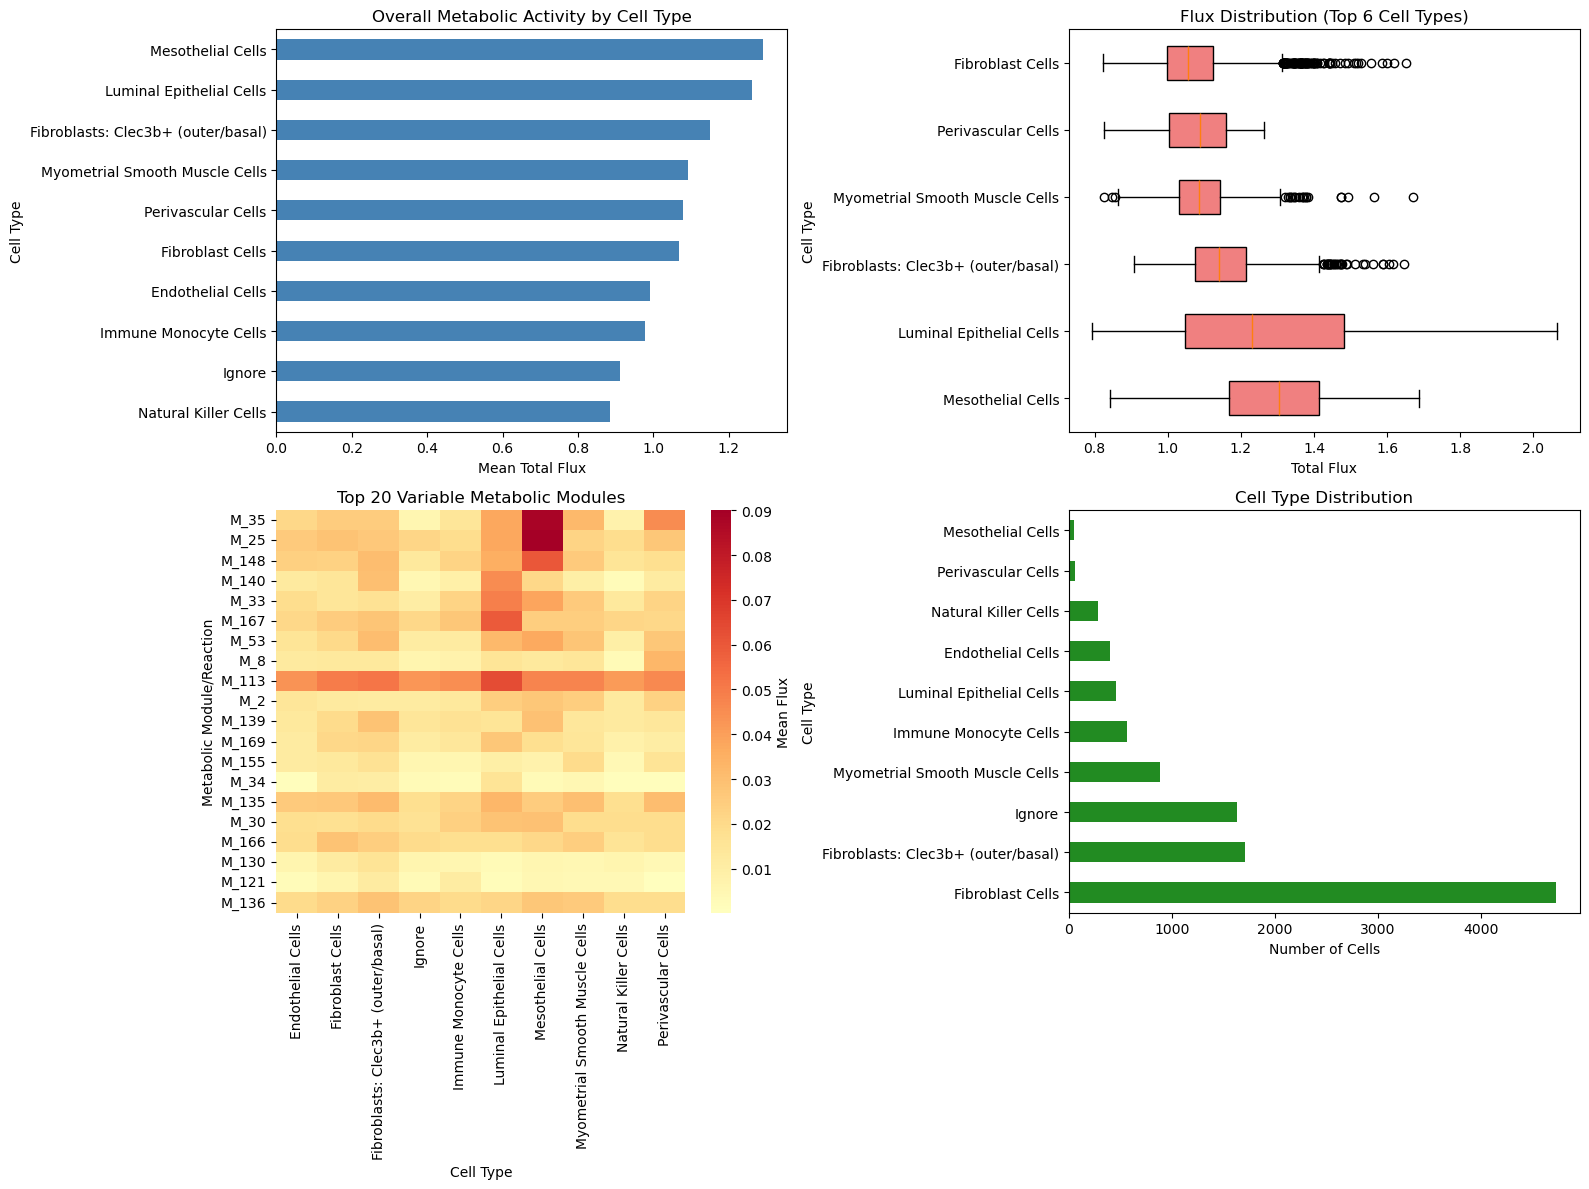


✓ Visualization complete!


In [25]:
# Visualize scFEA results
if flux_files:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total flux per cell type
    summary_stats.sort_values('mean')['mean'].plot(kind='barh', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_xlabel('Mean Total Flux')
    axes[0, 0].set_ylabel('Cell Type')
    axes[0, 0].set_title('Overall Metabolic Activity by Cell Type')
    
    # 2. Distribution of total flux
    cell_types = summary_stats.index[:6]  # Top 6 cell types
    data_for_box = [flux_summary[flux_summary['cell_type'] == ct]['total_flux'].values for ct in cell_types]
    bp = axes[0, 1].boxplot(data_for_box, labels=cell_types, vert=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
    axes[0, 1].set_xlabel('Total Flux')
    axes[0, 1].set_ylabel('Cell Type')
    axes[0, 1].set_title('Flux Distribution (Top 6 Cell Types)')
    
    # 3. Heatmap of top variable metabolic modules
    variance_per_module = mean_flux_by_type.var(axis=0).sort_values(ascending=False)
    top_modules = variance_per_module.head(20).index
    
    sns.heatmap(mean_flux_by_type[top_modules].T, cmap='RdYlBu_r', center=0,
                cbar_kws={'label': 'Mean Flux'}, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cell Type')
    axes[1, 0].set_ylabel('Metabolic Module/Reaction')
    axes[1, 0].set_title('Top 20 Variable Metabolic Modules')
    
    # 4. Cell count per type
    flux_by_cell['cell_type'].value_counts().plot(kind='barh', ax=axes[1, 1], color='forestgreen')
    axes[1, 1].set_xlabel('Number of Cells')
    axes[1, 1].set_ylabel('Cell Type')
    axes[1, 1].set_title('Cell Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete!")

    # Save figures if needed
    fig.savefig(scfea_dir / 'scFEA_analysis_plots.png', dpi=300)
else:
    print("Run scFEA first to generate flux predictions.")

## Save Results

CELL TYPE-SPECIFIC METABOLIC DIFFERENCES
Calculated total flux per cell

Cell types with sufficient cells in both stages (n≥20):
stage                               diestrus  estrus
cell_type                                           
Endothelial Cells                        306      96
Fibroblast Cells                        3353    1376
Fibroblasts: Clec3b+ (outer/basal)      1364     351
Ignore                                  1344     285
Immune Monocyte Cells                    327     241
Luminal Epithelial Cells                 355      99
Mesothelial Cells                         25      25
Myometrial Smooth Muscle Cells           643     243
Natural Killer Cells                     201      81

Metabolic differences by cell type:
                            cell_type  mean_estrus  mean_diestrus  log2_fc  \
5            Luminal Epithelial Cells       1.3883         1.2255   0.1800   
6                   Mesothelial Cells       1.3428         1.2396   0.1153   
7      Myometrial

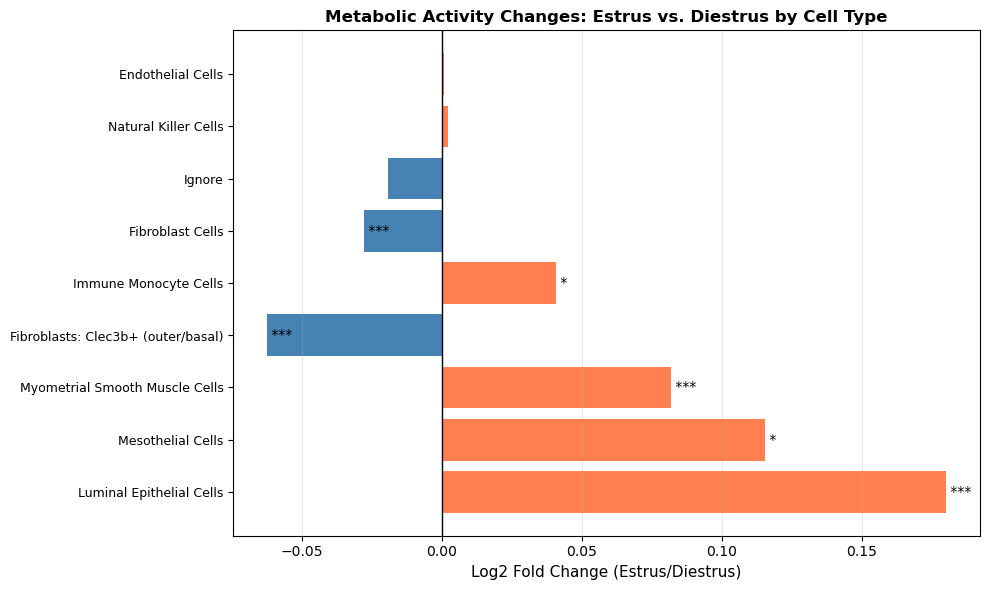

In [27]:
# Cell type-specific stage comparison
if flux_files and 'stage' in flux_by_cell.columns:
    from scipy import stats
    
    print("=" * 70)
    print("CELL TYPE-SPECIFIC METABOLIC DIFFERENCES")
    print("=" * 70)
    
    # Calculate total flux per cell (if not already done)
    if 'total_flux' not in flux_by_cell.columns:
        flux_by_cell['total_flux'] = flux_by_cell[module_cols].abs().sum(axis=1)
        print("Calculated total flux per cell")
    
    # Get cell types with enough cells in both stages (at least 20 cells each)
    cell_type_stage_counts = flux_by_cell.groupby(['cell_type', 'stage']).size().unstack(fill_value=0)
    valid_cell_types = cell_type_stage_counts[(cell_type_stage_counts['estrus'] >= 20) & 
                                               (cell_type_stage_counts['diestrus'] >= 20)].index
    
    print(f"\nCell types with sufficient cells in both stages (n≥20):")
    print(cell_type_stage_counts.loc[valid_cell_types])
    
    # Compare each cell type
    cell_type_results = []
    
    for cell_type in valid_cell_types:
        ct_data = flux_by_cell[flux_by_cell['cell_type'] == cell_type]
        
        estrus_ct = ct_data[ct_data['stage'] == 'estrus']['total_flux']
        diestrus_ct = ct_data[ct_data['stage'] == 'diestrus']['total_flux']
        
        t_stat, p_val = stats.ttest_ind(estrus_ct, diestrus_ct)
        
        cell_type_results.append({
            'cell_type': cell_type,
            'mean_estrus': estrus_ct.mean(),
            'mean_diestrus': diestrus_ct.mean(),
            'fold_change': estrus_ct.mean() / diestrus_ct.mean(),
            'log2_fc': np.log2(estrus_ct.mean() / diestrus_ct.mean()),
            'p_value': p_val,
            'n_estrus': len(estrus_ct),
            'n_diestrus': len(diestrus_ct)
        })
    
    ct_comparison = pd.DataFrame(cell_type_results)
    ct_comparison = ct_comparison.sort_values('log2_fc', key=abs, ascending=False)
    
    print("\nMetabolic differences by cell type:")
    print(ct_comparison[['cell_type', 'mean_estrus', 'mean_diestrus', 'log2_fc', 'p_value']].round(4))
    
    # Visualize
    fig_output_dir = f'../results/figures/{suffix}'
    os.makedirs(fig_output_dir, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['coral' if fc > 0 else 'steelblue' for fc in ct_comparison['log2_fc']]
    y_pos = np.arange(len(ct_comparison))
    
    ax.barh(y_pos, ct_comparison['log2_fc'], color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(ct_comparison['cell_type'], fontsize=9)
    ax.set_xlabel('Log2 Fold Change (Estrus/Diestrus)', fontsize=11)
    ax.set_title('Metabolic Activity Changes: Estrus vs. Diestrus by Cell Type', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linewidth=1)
    ax.grid(axis='x', alpha=0.3)
    
    # Add significance markers
    for i, (idx, row) in enumerate(ct_comparison.iterrows()):
        if row['p_value'] < 0.001:
            ax.text(row['log2_fc'], i, ' ***', va='center', fontsize=10)
        elif row['p_value'] < 0.01:
            ax.text(row['log2_fc'], i, ' **', va='center', fontsize=10)
        elif row['p_value'] < 0.05:
            ax.text(row['log2_fc'], i, ' *', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{fig_output_dir}/celltype_specific_stage_comparison.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved cell type comparison to: {fig_output_dir}/celltype_specific_stage_comparison.png")
    plt.show()
    
else:
    print("Stage information not available for cell type-specific comparison.")

Calculating module-level comparisons...


c:\Users\dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



✓ Saved comparison figure to: ../results/figures/combined.26.01.26/estrus_vs_diestrus_flux_comparison.png


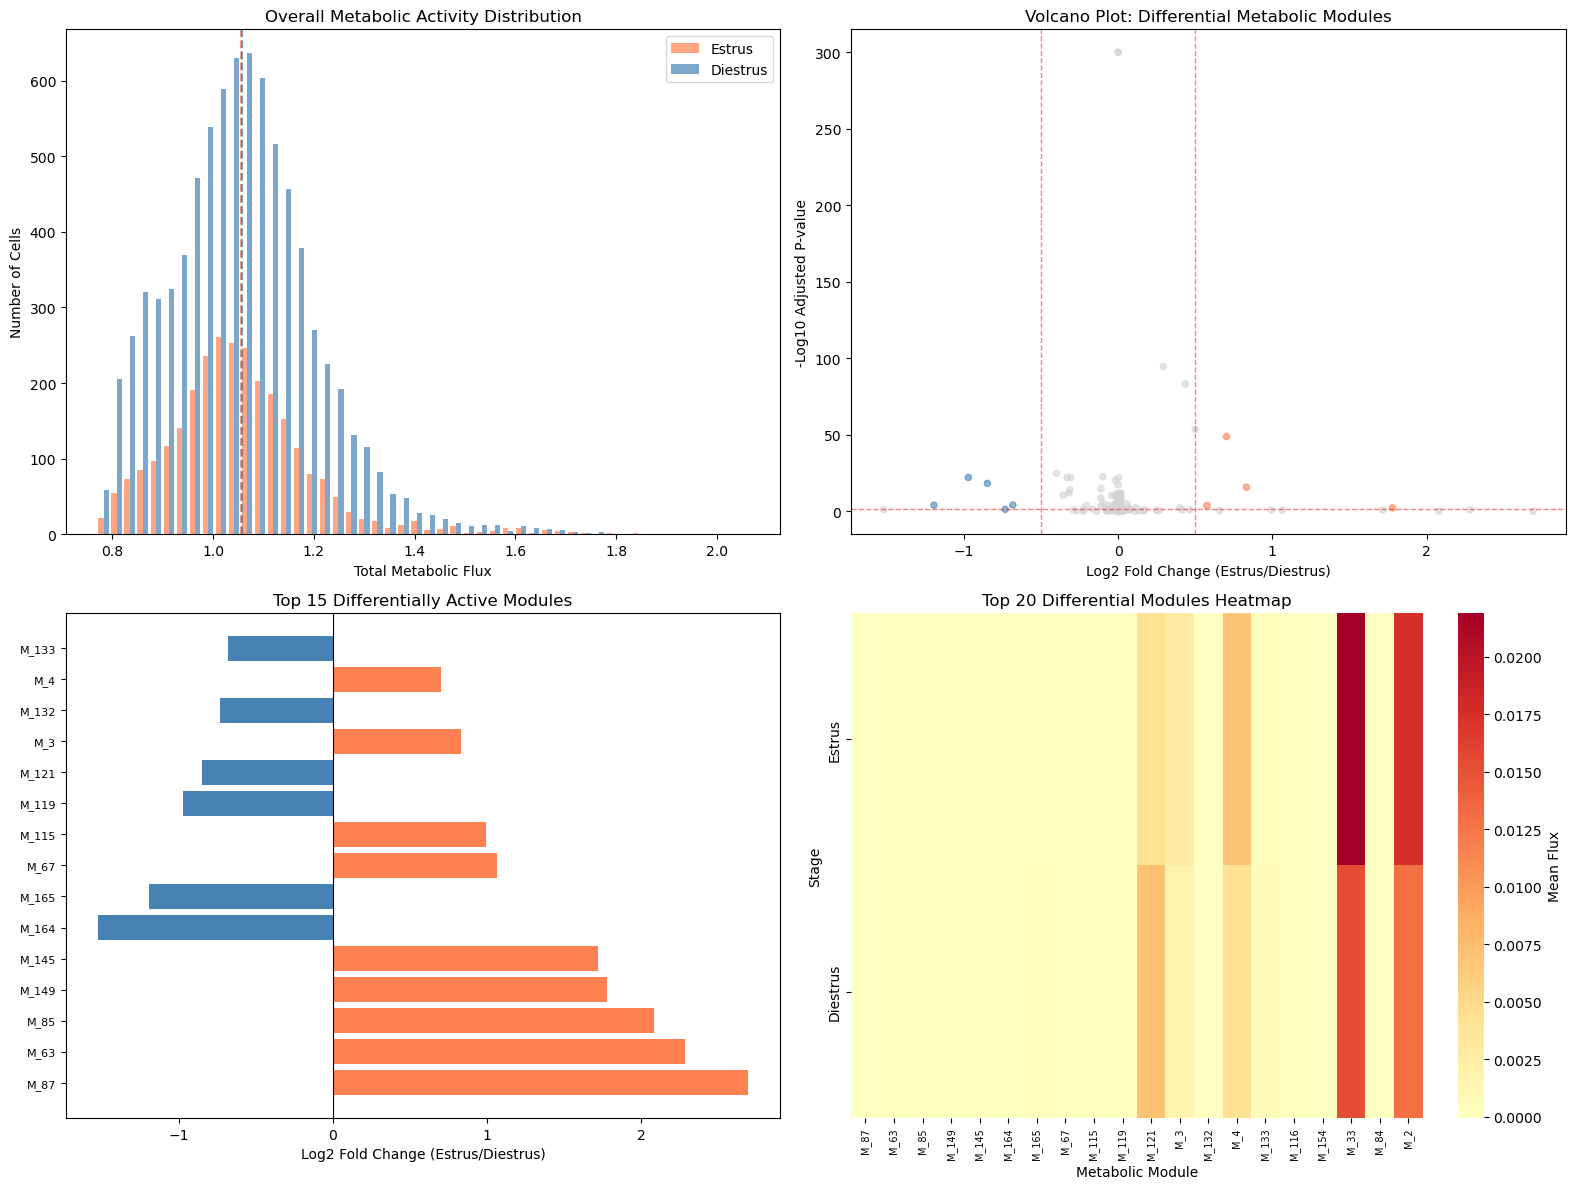

In [29]:
# Visualize estrus vs. diestrus comparison
if flux_files and 'stage' in flux_by_cell.columns:
    
    # Calculate module comparison if not already done
    if 'module_comparison' not in locals():
        print("Calculating module-level comparisons...")
        from scipy import stats
        from statsmodels.stats.multitest import multipletests
        
        # Calculate mean flux per module for each stage
        estrus_cells = flux_by_cell[flux_by_cell['stage'] == 'estrus']
        diestrus_cells = flux_by_cell[flux_by_cell['stage'] == 'diestrus']
        
        mean_estrus = estrus_cells[module_cols].mean()
        mean_diestrus = diestrus_cells[module_cols].mean()
        
        # Calculate fold change and p-values for each module
        module_comparison = pd.DataFrame({
            'mean_estrus': mean_estrus,
            'mean_diestrus': mean_diestrus,
            'fold_change': mean_estrus / (mean_diestrus + 1e-10),
            'log2_fc': np.log2(mean_estrus / (mean_diestrus + 1e-10)),
            'difference': mean_estrus - mean_diestrus
        })
        
        # Perform t-tests for each module
        p_values = []
        for module in module_cols:
            estrus_vals = estrus_cells[module].values
            diestrus_vals = diestrus_cells[module].values
            _, p = stats.ttest_ind(estrus_vals, diestrus_vals)
            p_values.append(p)
        
        module_comparison['p_value'] = p_values
        
        # Multiple testing correction (Benjamini-Hochberg)
        _, module_comparison['p_adjusted'], _, _ = multipletests(p_values, method='fdr_bh')
        
        # Sort by absolute log2 fold change
        module_comparison['abs_log2_fc'] = module_comparison['log2_fc'].abs()
        module_comparison_sorted = module_comparison.sort_values('abs_log2_fc', ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall metabolic activity distribution
    estrus_flux_vals = flux_by_cell[flux_by_cell['stage'] == 'estrus']['total_flux']
    diestrus_flux_vals = flux_by_cell[flux_by_cell['stage'] == 'diestrus']['total_flux']
    
    axes[0, 0].hist([estrus_flux_vals, diestrus_flux_vals], bins=50, alpha=0.7, 
                    label=['Estrus', 'Diestrus'], color=['coral', 'steelblue'])
    axes[0, 0].set_xlabel('Total Metabolic Flux')
    axes[0, 0].set_ylabel('Number of Cells')
    axes[0, 0].set_title('Overall Metabolic Activity Distribution')
    axes[0, 0].legend()
    axes[0, 0].axvline(estrus_flux_vals.mean(), color='coral', linestyle='--', alpha=0.8, label='Estrus mean')
    axes[0, 0].axvline(diestrus_flux_vals.mean(), color='steelblue', linestyle='--', alpha=0.8, label='Diestrus mean')
    
    # 2. Volcano plot of module differences
    volcano_data = module_comparison.copy()
    volcano_data['neg_log10_p'] = -np.log10(volcano_data['p_adjusted'] + 1e-300)
    
    # Color by significance and fold change
    colors = []
    for idx, row in volcano_data.iterrows():
        if row['p_adjusted'] < 0.05 and row['log2_fc'] > 0.5:
            colors.append('coral')  # Higher in estrus
        elif row['p_adjusted'] < 0.05 and row['log2_fc'] < -0.5:
            colors.append('steelblue')  # Higher in diestrus
        else:
            colors.append('lightgray')  # Not significant
    
    axes[0, 1].scatter(volcano_data['log2_fc'], volcano_data['neg_log10_p'], 
                      c=colors, alpha=0.6, s=20)
    axes[0, 1].axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].set_xlabel('Log2 Fold Change (Estrus/Diestrus)')
    axes[0, 1].set_ylabel('-Log10 Adjusted P-value')
    axes[0, 1].set_title('Volcano Plot: Differential Metabolic Modules')
    
    # 3. Top differential modules
    top_modules = module_comparison_sorted.head(15)
    y_pos = np.arange(len(top_modules))
    colors_bar = ['coral' if fc > 0 else 'steelblue' for fc in top_modules['log2_fc']]
    
    axes[1, 0].barh(y_pos, top_modules['log2_fc'], color=colors_bar)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(top_modules.index, fontsize=8)
    axes[1, 0].set_xlabel('Log2 Fold Change (Estrus/Diestrus)')
    axes[1, 0].set_title('Top 15 Differentially Active Modules')
    axes[1, 0].axvline(0, color='black', linewidth=0.8)
    
    # 4. Heatmap of top modules
    top_20_modules = module_comparison_sorted.head(20).index
    heatmap_data = pd.DataFrame({
        'Estrus': estrus_cells[top_20_modules].mean(),
        'Diestrus': diestrus_cells[top_20_modules].mean()
    })
    
    sns.heatmap(heatmap_data.T, cmap='RdYlBu_r', center=0, annot=False,
                cbar_kws={'label': 'Mean Flux'}, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Metabolic Module')
    axes[1, 1].set_ylabel('Stage')
    axes[1, 1].set_title('Top 20 Differential Modules Heatmap')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90, fontsize=7)
    
    plt.tight_layout()
    
    # Save figure
    fig_output_dir = f'../results/figures/{suffix}'
    os.makedirs(fig_output_dir, exist_ok=True)
    plt.savefig(f'{fig_output_dir}/estrus_vs_diestrus_flux_comparison.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved comparison figure to: {fig_output_dir}/estrus_vs_diestrus_flux_comparison.png")
    
    plt.show()
else:
    print("Stage information not available for visualization.")

In [30]:
# Identify differentially active metabolic modules between stages
if flux_files and 'stage' in flux_by_cell.columns:
    
    # Calculate mean flux per module for each stage
    estrus_cells = flux_by_cell[flux_by_cell['stage'] == 'estrus']
    diestrus_cells = flux_by_cell[flux_by_cell['stage'] == 'diestrus']
    
    mean_estrus = estrus_cells[module_cols].mean()
    mean_diestrus = diestrus_cells[module_cols].mean()
    
    # Calculate fold change and p-values for each module
    module_comparison = pd.DataFrame({
        'mean_estrus': mean_estrus,
        'mean_diestrus': mean_diestrus,
        'fold_change': mean_estrus / (mean_diestrus + 1e-10),  # Avoid division by zero
        'log2_fc': np.log2(mean_estrus / (mean_diestrus + 1e-10)),
        'difference': mean_estrus - mean_diestrus
    })
    
    # Perform t-tests for each module
    p_values = []
    for module in module_cols:
        estrus_vals = estrus_cells[module].values
        diestrus_vals = diestrus_cells[module].values
        _, p = stats.ttest_ind(estrus_vals, diestrus_vals)
        p_values.append(p)
    
    module_comparison['p_value'] = p_values
    
    # Multiple testing correction (Benjamini-Hochberg)
    from statsmodels.stats.multitest import multipletests
    _, module_comparison['p_adjusted'], _, _ = multipletests(p_values, method='fdr_bh')
    
    # Sort by absolute log2 fold change
    module_comparison['abs_log2_fc'] = module_comparison['log2_fc'].abs()
    module_comparison_sorted = module_comparison.sort_values('abs_log2_fc', ascending=False)
    
    print("=" * 70)
    print("TOP DIFFERENTIALLY ACTIVE METABOLIC MODULES")
    print("=" * 70)
    print("\nTop 20 modules with largest differences:")
    print(module_comparison_sorted[['mean_estrus', 'mean_diestrus', 'log2_fc', 'p_adjusted']].head(20).round(4))
    
    # Count significant modules
    sig_modules = (module_comparison['p_adjusted'] < 0.05).sum()
    print(f"\nSignificant modules (FDR < 0.05): {sig_modules}/{len(module_cols)}")
    
    # Store for visualization
    module_comparison_sorted.head(20)
else:
    print("Stage information not available for comparison.")

c:\Users\dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


TOP DIFFERENTIALLY ACTIVE METABOLIC MODULES

Top 20 modules with largest differences:
       mean_estrus  mean_diestrus  log2_fc  p_adjusted
M_87       -0.0000        -0.0000   2.6909      0.8410
M_63        0.0000         0.0000   2.2839      0.0989
M_85       -0.0000        -0.0000   2.0810      0.5855
M_149       0.0000         0.0000   1.7797      0.0046
M_145       0.0000         0.0000   1.7161      0.1143
M_164      -0.0000        -0.0000  -1.5216      0.0757
M_165       0.0000         0.0000  -1.1954      0.0001
M_67       -0.0000        -0.0000   1.0636      0.1582
M_115      -0.0000        -0.0000   0.9954      0.1262
M_119       0.0000         0.0000  -0.9721      0.0000
M_121       0.0040         0.0072  -0.8488      0.0000
M_3         0.0029         0.0016   0.8317      0.0000
M_132       0.0000         0.0000  -0.7330      0.0472
M_4         0.0068         0.0042   0.7024      0.0000
M_133       0.0003         0.0004  -0.6833      0.0001
M_116      -0.0000        -0.0000 

In [31]:
# Compare overall metabolic activity between stages
if flux_files and 'stage' in flux_by_cell.columns:
    from scipy import stats
    
    # Calculate total flux per cell
    module_cols = [col for col in flux_by_cell.columns if col not in ['cell_type', 'stage']]
    flux_by_cell['total_flux'] = flux_by_cell[module_cols].abs().sum(axis=1)
    
    # Compare by stage
    estrus_flux = flux_by_cell[flux_by_cell['stage'] == 'estrus']['total_flux']
    diestrus_flux = flux_by_cell[flux_by_cell['stage'] == 'diestrus']['total_flux']
    
    print("=" * 70)
    print("OVERALL METABOLIC ACTIVITY COMPARISON")
    print("=" * 70)
    print(f"\nEstrus (n={len(estrus_flux)}):")
    print(f"  Mean: {estrus_flux.mean():.4f}")
    print(f"  Median: {estrus_flux.median():.4f}")
    print(f"  Std: {estrus_flux.std():.4f}")
    
    print(f"\nDiestrus (n={len(diestrus_flux)}):")
    print(f"  Mean: {diestrus_flux.mean():.4f}")
    print(f"  Median: {diestrus_flux.median():.4f}")
    print(f"  Std: {diestrus_flux.std():.4f}")
    
    # Statistical test
    t_stat, p_value = stats.ttest_ind(estrus_flux, diestrus_flux)
    print(f"\nT-test: t={t_stat:.4f}, p={p_value:.4e}")
    if p_value < 0.001:
        print("*** Highly significant difference (p < 0.001)")
    elif p_value < 0.05:
        print("** Significant difference (p < 0.05)")
    else:
        print("No significant difference (p >= 0.05)")
    
    # Fold change
    fold_change = estrus_flux.mean() / diestrus_flux.mean()
    print(f"\nFold change (Estrus/Diestrus): {fold_change:.3f}x")
    
else:
    print("Stage information not available for comparison.")

OVERALL METABOLIC ACTIVITY COMPARISON

Estrus (n=2815):
  Mean: 2.1111
  Median: 2.0819
  Std: 0.2928

Diestrus (n=7964):
  Mean: 2.1135
  Median: 2.1006
  Std: 0.2918

T-test: t=-0.3718, p=7.1007e-01
No significant difference (p >= 0.05)

Fold change (Estrus/Diestrus): 0.999x


In [32]:
# Load flux results with stage information
if flux_files:
    # Reload cell metadata with stage information
    cell_metadata = pd.read_csv(metadata_file, index_col=0)
    
    # Check if stage information is in the annotated data
    if 'stage' in adata.obs.columns:
        print("✓ Stage information found in annotated data")
        cell_metadata['stage'] = adata.obs['stage']
        cell_metadata.to_csv(metadata_file)
        print(f"Updated metadata file with stage labels: {metadata_file}")
    else:
        print("⚠️ Stage information not found in adata.obs")
        print("Available columns:", adata.obs.columns.tolist())
        print("\nYou may need to re-run 02_cell_type_annotation.ipynb with concatenated data")
    
    # Merge flux with full metadata
    flux_by_cell = flux_results.copy()
    flux_by_cell.index.name = 'cell_barcode'
    flux_by_cell = flux_by_cell.join(cell_metadata[['cell_type', 'stage']], how='left')
    
    print(f"\nCombined dataset:")
    print(f"  Total cells: {len(flux_by_cell)}")
    if 'stage' in flux_by_cell.columns:
        print(f"  Estrus cells: {(flux_by_cell['stage'] == 'estrus').sum()}")
        print(f"  Diestrus cells: {(flux_by_cell['stage'] == 'diestrus').sum()}")
    print(f"  Cell types: {flux_by_cell['cell_type'].nunique()}")
    
    flux_by_cell.head()
else:
    print("Run scFEA first to generate flux predictions.")

✓ Stage information found in annotated data
Updated metadata file with stage labels: ..\results\scfea\combined.26.01.26\cell_metadata.csv

Combined dataset:
  Total cells: 10779
  Estrus cells: 2815
  Diestrus cells: 7964
  Cell types: 10


## Compare Estrus vs. Diestrus Metabolism

Now that we have combined flux data with stage labels, we can compare metabolic differences between estrus and diestrus.

In [33]:
# Save processed results
if flux_files:
    tab_output_dir = f'../results/tables/{suffix}'
    os.makedirs(tab_output_dir, exist_ok=True)
    
    # Save cell type-specific flux summaries
    output_file = f'{tab_output_dir}/flux_by_celltype.csv'
    mean_flux_by_type.to_csv(output_file)
    print(f"Saved cell type flux profiles to: {output_file}")
    
    # Save summary statistics
    summary_file = f'{tab_output_dir}/flux_summary.csv'
    summary_stats.to_csv(summary_file)
    print(f"Saved flux summary statistics to: {summary_file}")
    
    # Save stage comparison results if available
    if 'stage' in flux_by_cell.columns:
        module_comp_file = f'{tab_output_dir}/estrus_vs_diestrus_modules.csv'
        module_comparison_sorted.to_csv(module_comp_file)
        print(f"Saved module-level stage comparison to: {module_comp_file}")
        
        if 'ct_comparison' in locals():
            ct_comp_file = f'{tab_output_dir}/estrus_vs_diestrus_by_celltype.csv'
            ct_comparison.to_csv(ct_comp_file, index=False)
            print(f"Saved cell type-specific stage comparison to: {ct_comp_file}")
    
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"Cell types analyzed: {len(mean_flux_by_type)}")
    print(f"Total cells: {len(flux_by_cell)}")
    print(f"Metabolic modules/reactions: {flux_results.shape[1]}")
    
    if 'stage' in flux_by_cell.columns:
        print(f"\nStage comparison:")
        print(f"  Estrus cells: {(flux_by_cell['stage'] == 'estrus').sum()}")
        print(f"  Diestrus cells: {(flux_by_cell['stage'] == 'diestrus').sum()}")
        print(f"  Significant differential modules (FDR < 0.05): {sig_modules}")
    
    print(f"\nTop 5 metabolically active cell types:")
    for i, (ct, stats) in enumerate(summary_stats.head().iterrows(), 1):
        print(f"  {i}. {ct}: {stats['mean']:.2f} (mean flux)")
else:
    print("Run scFEA first to generate results.")

Saved cell type flux profiles to: ../results/tables/combined.26.01.26/flux_by_celltype.csv
Saved flux summary statistics to: ../results/tables/combined.26.01.26/flux_summary.csv
Saved module-level stage comparison to: ../results/tables/combined.26.01.26/estrus_vs_diestrus_modules.csv
Saved cell type-specific stage comparison to: ../results/tables/combined.26.01.26/estrus_vs_diestrus_by_celltype.csv

RESULTS SUMMARY
Cell types analyzed: 10
Total cells: 10779
Metabolic modules/reactions: 168

Stage comparison:
  Estrus cells: 2815
  Diestrus cells: 7964
  Significant differential modules (FDR < 0.05): 91

Top 5 metabolically active cell types:
  1. Mesothelial Cells: 1.29 (mean flux)
  2. Luminal Epithelial Cells: 1.26 (mean flux)
  3. Fibroblasts: Clec3b+ (outer/basal): 1.15 (mean flux)
  4. Myometrial Smooth Muscle Cells: 1.09 (mean flux)
  5. Perivascular Cells: 1.08 (mean flux)


## Next Steps

**Important: Install and run scFEA before proceeding:**

1. Install scFEA:
   ```bash
   pip install scFEA
   ```

2. Run scFEA (use command from cell above)

3. Once complete, proceed to `04_visualization.ipynb` for comprehensive analysis

### About scFEA

scFEA (single-cell Flux Estimation Analysis) is a graph neural network-based method that:
- Predicts metabolic flux from scRNA-seq data
- Uses 719 curated metabolic genes
- Accounts for reaction stoichiometry and constraints
- Provides cell-specific flux estimates

**Reference:** Alghamdi et al. (2021) "A graph neural network model to estimate cell-wise metabolic flux using single-cell RNA-seq data" *Genome Research*